### Sequential implementation

In [1]:
from scipy.stats import norm
import copy
import numpy as np
import itertools as itt
import time
import warnings
warnings.filterwarnings('ignore')


def get_H(m):
    k = 2**m - 1 - m
    n = 2**m - 1
    H = np.zeros((n, n-k))
    for i, comb in enumerate(itt.product([0,1], repeat=n-k)):
        if np.sum(comb) == 0:
            continue
        H[i-1, :] = np.array(comb)
    return H.astype(int)
    
def bpsk(x):
    y = np.where(x == 1, -np.ones_like(x), x)
    y = np.where(y == 0, np.ones_like(y), y)
    return y

def get_LLR(x):
    llr = np.ones_like(x)
    llr[0] = -0.5
    llr[-1] = -0.5
    return llr

def get_score(hard_decision, llr):
    return np.sum(hard_decision * np.abs(llr))

def get_H_row_idx(syndrome):
    idx = ''
    for i in syndrome:
        idx += str(i)
    idx = np.int(idx, base=2) - 1
    return idx

def process_combinations(llr, a, H):
    hard_decision = llr < 0
    sorting_idxs = np.argsort(np.abs(llr))[:a]
    scores = []
    hd_list = []
    for vals in itt.product([0, 1], repeat=a):
        new_hard_decision = copy.deepcopy(hard_decision)
        new_hard_decision[sorting_idxs] = np.asarray(vals)
        syndrome = (new_hard_decision @ H) % 2
        H_row_idx = get_H_row_idx(syndrome)
        if H_row_idx != -1:
            new_hard_decision[H_row_idx] = (new_hard_decision[H_row_idx] + 1) % 2
        scores.append(get_score(new_hard_decision, llr))
        hd_list.append(new_hard_decision)
    return scores, hd_list

def chase_code(a, H):
    code_word = bpsk(np.zeros(H.shape[0]))
    llr = get_LLR(code_word)
    start_time = time.time()
    scores, hd_list = process_combinations(llr, a, H)
    stop_time = time.time()
    best_score_idx = np.argmin(scores)
    return hd_list[best_score_idx], stop_time - start_time
    
    

In [2]:
m = 12
a = 6
n = 2**m - 1
H = get_H(m)
N = 1000
times = []
for _ in range(N):
    res, t = chase_code(a, H)
    times.append(t)
times = np.array(times)

print(f'times.sum(): {times.sum()}')
print(f'times.mean(): {times.mean()}')
print(f'times.std(): {times.std()}')

times.sum(): 11.4188232421875
times.mean(): 0.0114188232421875
times.std(): 0.00034044061888356306


### Numba

In [3]:
from numba import jit

@jit(nopython=False) 
def get_H_numba(m):
    k = 2**m - 1 - m
    n = 2**m - 1
    H = np.zeros((n, n-k))
    for i, comb in enumerate(itt.product([0,1], repeat=n-k)):
        if np.sum(comb) == 0:
            continue
        H[i-1, :] = np.array(comb)
    return H.astype(int)

@jit(nopython=True) 
def bpsk_numba(x):
    y = np.where(x == 1, -np.ones_like(x), x)
    y = np.where(y == 0, np.ones_like(y), y)
    return y

@jit(nopython=True)
def get_LLR_numba(x):
    llr = np.ones_like(x)
    llr[0] = -0.5
    llr[-1] = -0.5
    return llr

@jit(nopython=True)
def get_score_numba(hard_decision, llr):
    return np.sum(hard_decision * np.abs(llr))

def get_H_row_idx_numba(syndrome):
    idx = ''
    for i in syndrome:
        idx += str(i)
    idx = np.int(idx, base=2) - 1
    return idx

@jit(nopython=False)
def process_combinations_numba(llr, a, H):
    hard_decision = llr < 0
    sorting_idxs = np.argsort(np.abs(llr))[:a]
    scores = []
    hd_list = []
    vals_list = list(itt.product([0, 1], repeat=a))
    for vals in vals_list:
        new_hard_decision = copy.deepcopy(hard_decision)
        new_hard_decision[sorting_idxs] = vals
        syndrome = (new_hard_decision @ H) % 2
        H_row_idx = get_H_row_idx_numba(syndrome)
        if H_row_idx != -1:
            new_hard_decision[H_row_idx] = (new_hard_decision[H_row_idx] + 1) % 2
        scores.append(get_score_numba(new_hard_decision, llr))
        hd_list.append(new_hard_decision)
    return scores, hd_list

@jit(nopython=False) 
def chase_code_numba(a, H):
    code_word = bpsk_numba(np.zeros(H.shape[0]))
    llr = get_LLR_numba(code_word)
    start_time = time.time()
    scores, hd_list = process_combinations_numba(llr, a, H)
    stop_time = time.time()
    best_score_idx = np.argmin(scores)
    return hd_list[best_score_idx], stop_time - start_time
    
    

In [4]:
m = 12
a = 6
n = 2**m - 1
H = get_H(m)
N = 1000
times_numba = []
for _ in range(N):
    res, t = chase_code_numba(a, H)
    times_numba.append(t)
times_numba = np.array(times_numba)
times_numba_real = times_numba[1:]

print(f'times_numba.sum(): {times_numba.sum()}')
print(f'times_numba.mean(): {times_numba.mean()}')
print(f'times_numba.std(): {times_numba.std()}')

print(f'times_numba_real.sum(): {times_numba_real.sum()}')
print(f'times_numba_real.mean(): {times_numba_real.mean()}')
print(f'times_numba_real.std(): {times_numba_real.std()}')

times_numba.sum(): 11.596175193786621
times_numba.mean(): 0.01159617519378662
times_numba.std(): 0.021683417232362803
times_numba_real.sum(): 10.899255275726318
times_numba_real.mean(): 0.010910165441167486
times_numba_real.std(): 0.0001784472142057775


In [5]:
print(f'Numba speed-up: {times.mean() / times_numba_real.mean()}')

Numba speed-up: 1.0466223728469497


### Parallel implementation

In [6]:
# try:
#     import mpi4py
# except ModuleNotFoundError:
#     !pip3 install mpi4py

In [7]:
%%writefile chase_code.py
from scipy.stats import norm
import copy
import numpy as np
import itertools as itt
from mpi4py import MPI

def get_H(m):
    k = 2**m - 1 - m
    n = 2**m - 1
    H = np.zeros((n, n-k))
    for i, comb in enumerate(itt.product([0, 1], repeat=n-k)):
        if np.sum(comb) == 0:
            continue
        H[i-1, :] = np.array(comb)
    return H.astype(int)
    
def bpsk(x):
    y = np.where(x == 1, -np.ones_like(x), x)
    y = np.where(y == 0, np.ones_like(y), y)
    return y

def get_LLR(x):
    llr = np.ones_like(x)
    llr[0] = -0.5
    llr[-1] = -0.5
    return llr

def get_score(hard_decision, llr):
    return np.sum(hard_decision * np.abs(llr))

def get_H_row_idx(syndrome):
    idx = ''
    for i in syndrome:
        idx += str(i)
    idx = int(idx, base=2) - 1
    return idx

def process_combinations(llr, a, H, mpisize, mpirank):
    hard_decision = llr < 0
    sorting_idxs = np.argsort(np.abs(llr))[:a]
    scores = []
    hd_list = []
    vals_list = list(itt.product([0, 1], repeat=a))
    vals_per_proc = 2**a // mpisize
    residuals = 2**a % mpisize
    if mpirank < residuals:
        vals_per_proc += 1
        start_idx = mpirank * vals_per_proc
        stop_idx = (mpirank + 1) * vals_per_proc
    else:
        start_idx = mpirank * vals_per_proc + residuals
        stop_idx = (mpirank + 1) * vals_per_proc + residuals
    vals_list = vals_list[start_idx:stop_idx]   
    for vals in vals_list:
        new_hard_decision = copy.deepcopy(hard_decision)
        new_hard_decision[sorting_idxs] = vals
        # new_hard_decision[sorting_idxs] = np.asarray(vals)
        syndrome = (new_hard_decision @ H) % 2
        H_row_idx = get_H_row_idx(syndrome)
        if H_row_idx != -1:
            new_hard_decision[H_row_idx] = (new_hard_decision[H_row_idx] + 1) % 2
        scores.append(get_score(new_hard_decision, llr))
        hd_list.append(new_hard_decision)
    return scores, hd_list

def chase_code(a, H, mpisize, mpirank):
    code_word = bpsk(np.zeros(H.shape[0]))
    llr = get_LLR(code_word)
    start_time = MPI.Wtime()
    scores_part, hd_list_part = process_combinations(llr, a, H, mpisize, mpirank)
    stop_time = MPI.Wtime()
    scores = []
    scores = comm.gather(scores_part, root=0)
    hd_list = comm.gather(hd_list_part, root=0)
    gathered_time = comm.gather(stop_time - start_time, root=0)
    if mpirank == 0:
        scores = [i for batch in scores for i in batch]
        hd_list = [i for batch in hd_list for i in batch]
        return hd_list[np.argmin(scores)], gathered_time
    else:
        return None



comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

m = 14
a = 9
n = 2**m - 1
H = get_H(m)
N = 100

times = []
for _ in range(N):
    if rank == 0:
        res, time = chase_code(a, H, size, rank)
        times.append(np.max(time))
    else:
        chase_code(a, H, size, rank)

if rank == 0:
    with open(f'{size}.txt', "a") as f:
        f.write(str(np.mean(times)) + '\n')


Writing chase_code.py


In [8]:
N = 8
for n in range(1, N+1):
    !mpiexec --allow-run-as-root -n {n} python chase_code.py


In [9]:
import os

speed_ups = []
for i in range(1, N+1):
    f_name = f'{i}.txt'
    with open(f_name, "r") as f:
        res = f.readlines()
        res = np.array(res, dtype=float)
    speed_ups.append(res.mean())
    # os.remove(f_name)

speed_ups = np.array(speed_ups)
speed_ups = 1 / speed_ups * speed_ups[0]

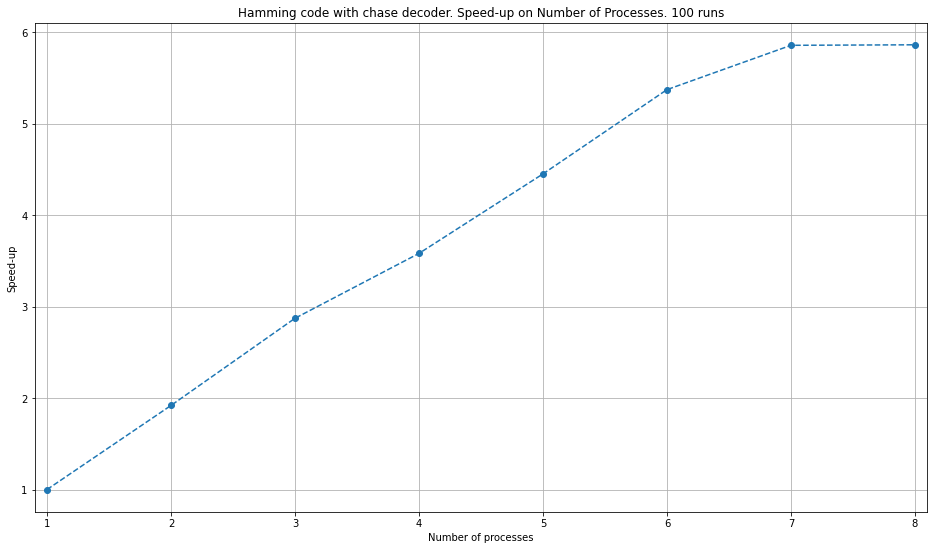

In [13]:
from matplotlib import pyplot as plt
runs_num = 100 # must be equal to N in chase_code.py
plt.figure(figsize=(16, 9))
plt.title(f'Hamming code with chase decoder. Speed-up on Number of Processes. {runs_num} runs')
plt.xlabel('Number of processes')
plt.ylabel('Speed-up')
plt.grid()
plt.xlim(1-0.1, N+0.1)
plt.plot(np.arange(1, N+1), speed_ups, '--o');
plt.savefig('hamming_code_chase_decoder_speedup.png', dpi=100);

<Figure size 432x288 with 0 Axes>